# Loading data

Start by loading data and converting the columns from questions to names. Shuffle rows for privacy.

In [80]:
import pandas as pd
import scipy.stats as sp

df = pd.read_csv('responses3.tsv',
                 sep = '\t')

In [81]:
print df.columns

Index([u'Timestamp', u'How old are you?', u'What grade are you in?',
       u'What do you want to do when you grow up? (probably forgetting things, feel free to liberally use the "Other" box)',
       u'Have you been in any relationships (>1 month long) in high school?',
       u'How many >1 month relationships have you been in while in high school? (yes, I know I can infer the answer to the previous question from the data for this one, but I am adding this question later and therefore cannot edit the previous one)',
       u'What is your weighted GPA? (can check on Harker transcript, or can just give approximate value, or calculate here, courtesy of Neeraj: tiny.cc/gpa)',
       u'What is your unweighted GPA? (4.0 is maximum; can just give approximate value, or calculate here: tiny.cc/gpa)',
       u'What's your favorite subject?',
       u'Broadly speaking, do you feel stressed?',
       u'What classes are you taking? Please list using separate lines per class.',
       u'What ethnic

In [82]:
df.columns = ['time', 'age', 'grade', 'occupation',
              'relation_binary', 'relation_num', 'wgpa', 'ugpa',
              'favsubj', 'stress', 'classes', 'race', 
              'honors', 'drive', 'aps', 'iq', 'hobby',
              'music', 'college', 'gender', 'sleep',
              'mtgs', 'teacher1', 'teacher2']

In [83]:
df = df.sample(frac=1).reset_index(drop=True)

# Categorical relationships with statistical tests

First comparison - weighted GPA in stressed groups vs. non-stressed groups

In [84]:
print len(df['wgpa'])

58


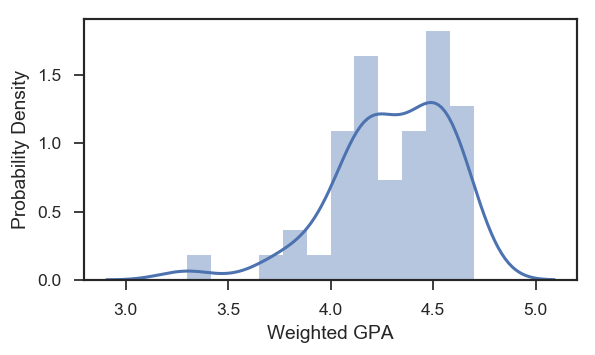

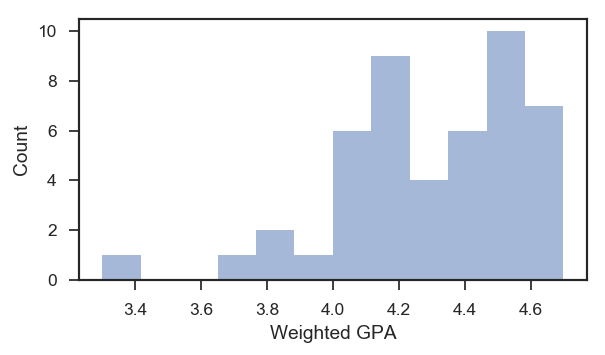

In [85]:
# Distribution of weighted GPAs

import numpy as np
import seaborn as sns

nonNan = np.logical_not(np.isnan(df['wgpa']))

plt.figure(figsize=(5,3), dpi=125)
ax = sns.distplot(df['wgpa'][nonNan], bins = 12)

ax.set_xlabel('Weighted GPA')
ax.set_ylabel('Probability Density')

plt.tight_layout()
plt.savefig("wgpa_kde.png")
plt.show()

plt.figure(figsize=(5,3), dpi=125)
ax = sns.distplot(df['wgpa'][nonNan], kde = False, bins = 12, 
                  hist_kws = {"linewidth": 2,
                              "alpha": 0.5})

ax.set_xlabel('Weighted GPA')
ax.set_ylabel('Count')

plt.tight_layout()
plt.savefig("wgpa_hist.png")
plt.show()

In [103]:
print len(df['wgpa'][nonNan])
print np.mean(df['wgpa'][nonNan])
print np.median(df['wgpa'][nonNan])

47
4.29893617021
4.32


In [86]:
# stressGpas = df['wgpa'][df['stress'] == 'Yes']
# unstressGpas = df['wgpa'][df['stress'] == 'No']
stressGpas = df['wgpa'][np.logical_and(df['stress'] == 'Yes', nonNan)]
unstressGpas = df['wgpa'][np.logical_and(df['stress'] == 'No', nonNan)]

print len(stressGpas)
print len(unstressGpas)

print np.nanmean(stressGpas)
print np.nanmean(unstressGpas)
print sp.ttest_ind(stressGpas, unstressGpas)
print sp.mannwhitneyu(stressGpas, unstressGpas)

24
23
4.1975
4.4047826087
Ttest_indResult(statistic=-2.6548429325363418, pvalue=0.010931763356408981)
MannwhitneyuResult(statistic=164.0, pvalue=0.0087677714258454515)


The p-value appears pretty significant (probability of these data if there were no relationship = 0.002) that people who report not being stressed have higher GPA. This could probably (at least, in part) be explained by reporting bias, but still interesting.

Let's visualize this in a boxplot:

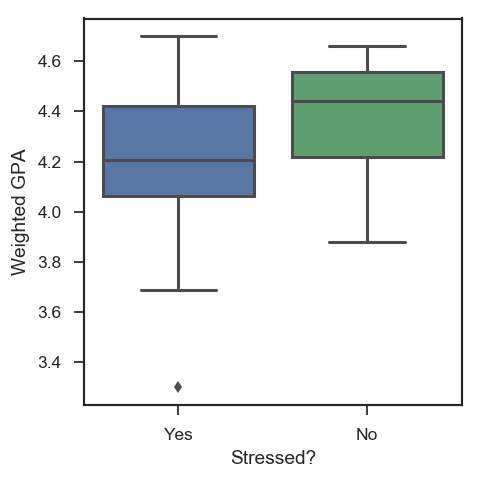

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style = 'ticks',
        font = 'Arial')

plt.figure(figsize=(4,4), dpi=125)

# Note that seaborn's plotting auto-ignores NaNs
ax = sns.boxplot(data = df, y = 'wgpa', x = 'stress')

ax.set_xlabel("Stressed?")
ax.set_ylabel("Weighted GPA")

plt.tight_layout()
plt.savefig('wgpa_vs_stress.png', dpi=300)
plt.show()

An analogous comparison - GPA vs. relationship.

23
24
4.31391304348
4.28458333333
Ttest_indResult(statistic=0.34976528621958808, pvalue=0.72814655298801267)
MannwhitneyuResult(statistic=268.5, pvalue=0.4407291373654611)


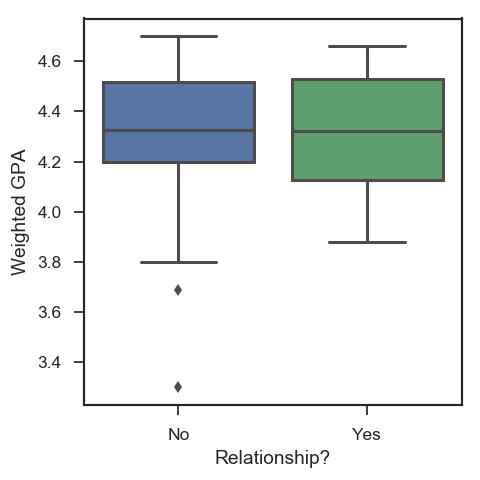

In [88]:
relationGpas = df['wgpa'][np.logical_and(df['relation_binary'] == 'Yes', nonNan)]
norelationGpas = df['wgpa'][np.logical_and(df['relation_binary'] == 'No', nonNan)]

print len(relationGpas)
print len(norelationGpas)

print np.nanmean(relationGpas)
print np.nanmean(norelationGpas)
print sp.ttest_ind(relationGpas, norelationGpas)
print sp.mannwhitneyu(relationGpas, norelationGpas)

plt.figure(figsize=(4,4), dpi=125)

ax = sns.boxplot(data = df, y = 'wgpa', x = 'relation_binary')

ax.set_xlabel("Relationship?")
ax.set_ylabel("Weighted GPA")

plt.tight_layout()
plt.savefig('wgpa_vs_relationship.png', dpi=300)
plt.show()

Looks like no statistically relevant dependency between GPA and relationship. $P = 0.32$, which is insignificant.

# Correlations between variables

Correlation between sleep and weighted GPA:

SpearmanrResult(correlation=0.18073312699852165, pvalue=0.22409118128132532)


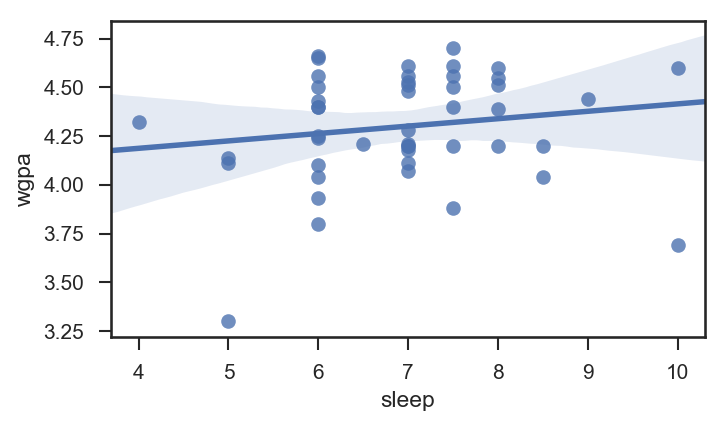

In [99]:
nonNanSleepGpa = np.logical_and(np.logical_not(np.isnan(df['sleep'])), np.logical_not(np.isnan(df['wgpa'])))

print sp.spearmanr(df['sleep'][nonNanSleepGpa], df['wgpa'][nonNanSleepGpa])

plt.figure(figsize = (5,3), dpi = 150)

sns.regplot(df['sleep'][nonNanSleepGpa],
            df['wgpa'][nonNanSleepGpa])

plt.tight_layout()
plt.savefig('wgpa_vs_sleep.png', dpi=300)
plt.show()

In [170]:
import math
from collections import OrderedDict

teacherCts = OrderedDict()

for i in range(len(df['teacher1'])):
    for teacher in (df['teacher1'][i], df['teacher2'][i]):
        if teacher not in teacherCts:
            teacherCts[teacher] = 0
        teacherCts[teacher] += 1
        
print sorted(teacherCts.items(), key=lambda x:-x[1])

[(nan, 35), ('Horan', 5), ('Lepler', 5), ('Wheeler', 5), ('Silk', 4), ('Datar', 4), ('Adler', 4), ('Halback', 4), ('Hurshman', 4), ('Casso', 3), ('Douglas', 3), ('Miller', 2), ('Sutton', 2), ('Thiele', 2), ('Stahl', 2), ('Paskali', 2), ('Spenner', 2), ('Gelineau', 1), ('Blickenstaff', 1), ('Nace', 1), ('Green ', 1), ('Rees', 1), ('Pianko ', 1), ('Manning', 1), ('Momenian', 1), ('Docherty', 1), ('Koodenjeri', 1), ('Florio', 1), ('Doherty', 1), ('Harley', 1), ('Aridomi', 1), ('Pianko', 1), ('Nelson', 1), ('Raghavan ', 1), ('Raghavan', 1), ('Green', 1), ('Hufnagl', 1), ('Achten', 1), ('Martinez', 1), ('Aiyer', 1), ('Pistacchi', 1), ('Chetty', 1), ('Stoll', 1), ('Koodanjeri', 1), ('Brada', 1)]


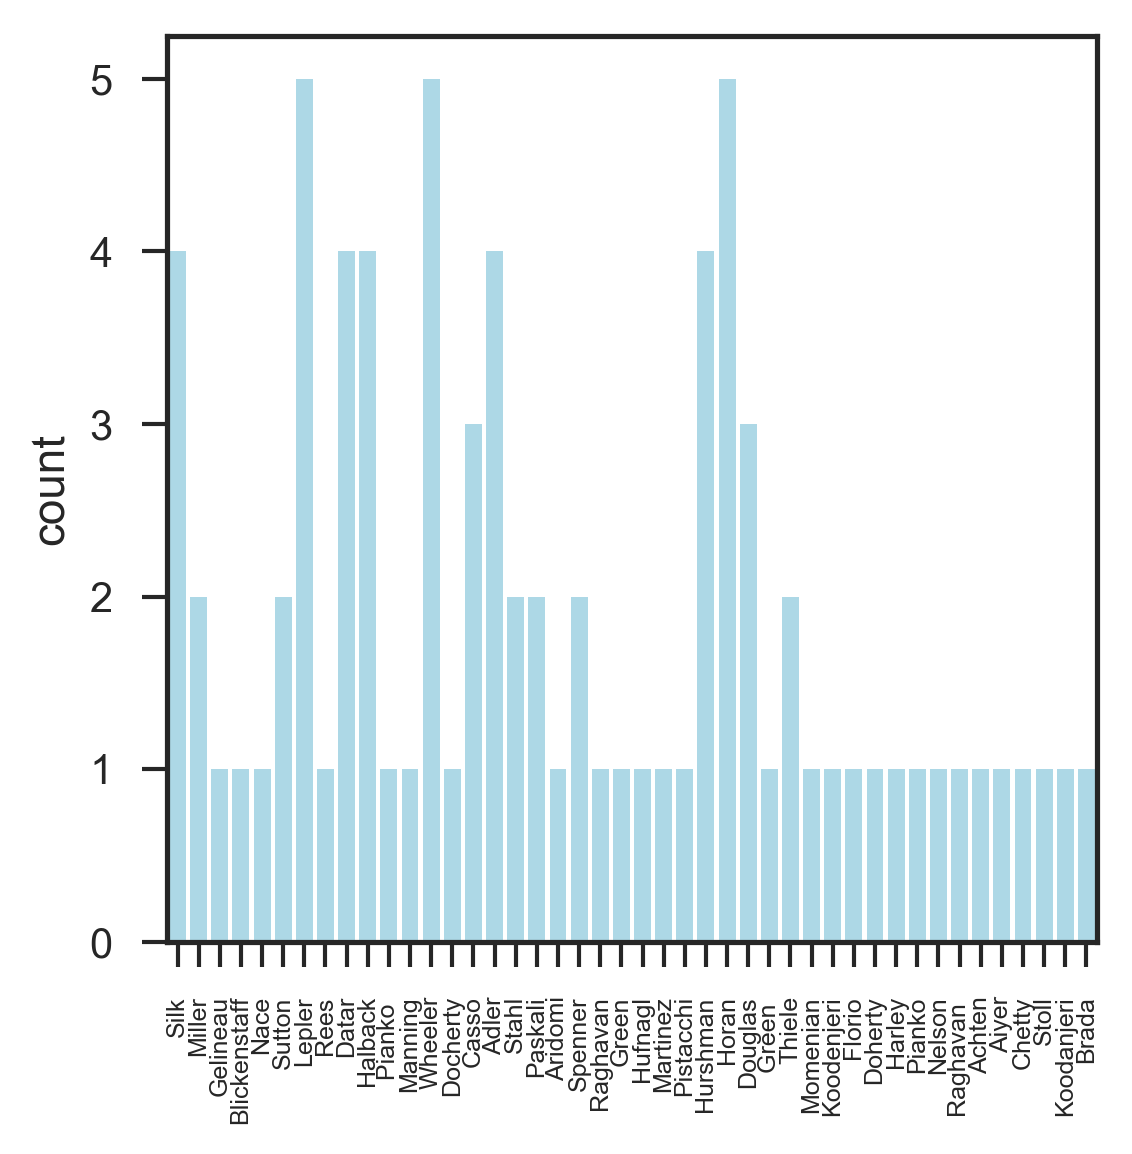

In [167]:
plt.figure(figsize = (4,4), dpi=300)


ax = sns.countplot(np.concatenate((df['teacher1'],df['teacher2'])),
                   orient = False,
                   color = 'lightblue', saturation = 1)

plt.xticks(fontsize=6, rotation=90)

plt.show()